<a href="https://colab.research.google.com/github/Ap1phu/ML-Supercap/blob/main/Senior_Project_ML_model_10_folds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Relevant Libraries

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from statistics import mean
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression,Ridge
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.gaussian_process import GaussianProcessRegressor,kernels

## Import Data

In [ ]:
raw_csv_data_pd = pd.read_csv("https://raw.githubusercontent.com/Ap1phu/Data-Supcap/main/Preprocess%20Data%204%20June.csv?token=GHSAT0AAAAAAB4KCDBWO7OHSKQ7YPXSWNQWY4X45XA")
raw_csv_data = raw_csv_data_pd.to_numpy()
unscaled_inputs = raw_csv_data[:,0:-1]
targets_all = raw_csv_data[:,-1]
print(unscaled_inputs.shape)
print(targets_all.shape)

(315, 11)
(315,)


In [ ]:
np.random.seed(42)
shuffled_indices=np.arange(targets_all.shape[0])
np.random.shuffle(shuffled_indices)
np.random.shuffle(shuffled_indices)
shuffled_inputs = unscaled_inputs[shuffled_indices]
shuffled_targets = targets_all[shuffled_indices]

##Hold out test set (split train and test)
Note: Validation split at k-fold

In [ ]:
samples_count = shuffled_inputs.shape[0]
train_samples_count = int(0.9 * samples_count)
train_inputs = shuffled_inputs[:train_samples_count]
train_targets = shuffled_targets[:train_samples_count]
test_inputs = shuffled_inputs[train_samples_count:]
test_targets = shuffled_targets[train_samples_count:]
print(test_inputs.shape)

(32, 11)


##Scaler+PCA

In [ ]:
def preprocess(train,validation,test):
  scaler=StandardScaler()
  scaler.fit(train)
  scaled_train_inputs=scaler.transform(train)
  scaled_validation_inputs=scaler.transform(validation)
  scaled_test_inputs=scaler.transform(test)
  X,Y,Z = pca_scale(scaled_train_inputs,scaled_validation_inputs,scaled_test_inputs)
  return X,Y,Z

def pca_scale(train,validation,test):
  pca=PCA(n_components = 9)
  reduced_train_inputs=pca.fit_transform(train)
  reduced_validation_inputs=pca.transform(validation)
  reduced_test_inputs=pca.transform(test)
  return reduced_train_inputs,reduced_validation_inputs,reduced_test_inputs

##Show Performance Function

In [ ]:
def perform(train_val_acc,pred_train,pred_test):
  print("R-square on train is",train_val_acc[:,0])
  print("R-square on validation is",train_val_acc[:,1])
  print("RMSE on train is", (1-train_val_acc[:,0])*TSS[:,0])
  print("RMSE on validation is", (1-train_val_acc[:,1])*TSS[:,1])
  print("Average R-square on train is",np.mean(train_val_acc,axis=0)[0],"Average R-square on validation is",np.mean(train_val_acc,axis=0)[1])
  print("R-square on test set is",r2_score(test_targets,np.mean(pred_test,axis=1)))
  print("RMSE on test set is", mean_squared_error(test_targets,np.mean(pred_test,axis=1)))
  plt.scatter(np.squeeze(np.mean(pred_train,axis=1)),np.squeeze(train_targets),s=20)
  plt.scatter(np.squeeze(np.mean(pred_test,axis=1)),np.squeeze(test_targets),c='red',s=20)
  plt.plot(shuffled_targets,shuffled_targets,c='orange')
  plt.xlabel("Predicted value (F/g)", fontsize=18)
  plt.ylabel("Experimental value(F/g)", fontsize=18)
  plt.xlim([0,400])
  plt.ylim([-10,400])
  plt.show()

##LR+CV

In [ ]:
def LR(X_train,y_train,X_validation,y_validation,X_test,i):   #Model must update train_val_acc,pred_train,pred_test
  #Model
  reg=LinearRegression()
  reg.fit(X_train,y_train)
  #Predict and Evaluate
  train_val_acc[i,:]=np.array([reg.score(X_train,y_train),reg.score(X_validation,y_validation)])
  pred_train[:,i]=reg.predict(np.insert(X_train,validation_index[0],X_validation,axis=0))   #Unmix the pred_train for plotting
  pred_test[:,i]=reg.predict(X_test)

R-square on train is [0.1606477  0.15654157 0.14123003 0.14257836 0.16308532 0.14769566
 0.19749884 0.14724945 0.15312181 0.19575959]
R-square on validation is [-0.21448836  0.0845706   0.18126067  0.15889259 -0.06851004  0.2609248
 -0.32046688  0.11822576  0.10232656 -0.16116314]
RMSE on train is [7042.96719755 7044.45601349 6896.77911008 6877.52794306 7193.03735627
 7415.49495025 6700.15506361 6981.48659414 7064.9369396  6532.32901254]
RMSE on validation is [ 8292.04967972  7273.53726068  8824.21294245  9083.82006244
  5241.97668321  3463.88309437 10516.18592057  7489.86084805
  7171.87507243 11537.01670442]
Average R-square on train is 0.16054083292998741 Average R-square on validation is 0.014157256713493072
R-square on test set is 0.3563990846317431
RMSE on test set is 4792.613946267944


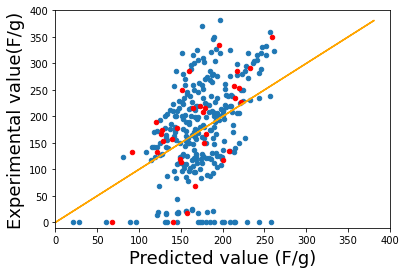

In [ ]:
#Initiate some arrays
k , i = 10 , 0
kf = KFold(n_splits=k)
pred_train , pred_test = np.zeros((train_inputs.shape[0],k)) , np.zeros((test_inputs.shape[0],k)) 
train_val_acc , TSS =np.zeros((k,2)) , np.zeros((k,2))

#Split,CV,Preprocess
for train_index, validation_index in kf.split(train_targets):
  X_train, X_validation = train_inputs[train_index], train_inputs[validation_index]
  y_train, y_validation = train_targets[train_index], train_targets[validation_index]
  Test=test_inputs
  X_train_prep, X_validation_prep, X_test_prep = preprocess(X_train, X_validation,Test)
  TSS[i,0]=np.mean((y_train-np.mean(y_train))**2)
  TSS[i,1]=np.mean((y_validation-np.mean(y_validation))**2)

  #Model Here
  LR(X_train_prep,y_train,X_validation_prep,y_validation,X_test_prep,i)
  i+=1
#Show Performance
perform(train_val_acc,pred_train,pred_test)

##ANN+L2+CV

In [ ]:
def PlotLC(Learning_curve):
  #np.save(F"/content/drive/MyDrive/ANN Model/3Learning_curve", Learning_curve)
  loss , val_loss = Learning_curve[:,0] , Learning_curve[:,1]
  indices=np.linspace(1,Learning_curve.shape[0],num=Learning_curve.shape[0])
  plt.plot(indices,loss,c='orange')
  plt.plot(indices,val_loss,c='purple')
  plt.xlabel("Iterations", fontsize=18)
  plt.ylabel("Loss", fontsize=18)
  plt.xlim([0,Learning_curve.shape[0]])
  plt.ylim([0,5000])
  plt.show() 

In [ ]:
def ANN(X_train,y_train,X_validation,y_validation,X_test,i,Learning_curve):
  #Model
  input_size = 9
  output_size = 1
  hidden_layer_size_1 = 30
  max_epochs = 300
  model = tf.keras.Sequential([
        tf.keras.layers.Dense(hidden_layer_size_1, activation='tanh',kernel_regularizer=tf.keras.regularizers.L2(0.01)), # 1st hidden layer
        tf.keras.layers.Dense(output_size, activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.01)) # output layer
    ])
  lr_schedule=0.1
  customized_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
  model.compile(optimizer=customized_optimizer, loss='mse', metrics=['mean_squared_error'])
  history=model.fit(X_train, # train inputs
            y_train, # train targets
            epochs=max_epochs, # epochs that we will train for
            validation_data=(X_validation, y_validation), # validation data
            verbose = 0 # making sure we get enough information about the training process 2 is reporting everything
            )
    
  #Predict and Evaluate
  train_val_acc[i,:]=np.array([r2_score(y_train,model.predict(X_train)),r2_score(y_validation,model.predict(X_validation))])
  pred_train[:,i]=model.predict(np.insert(X_train,validation_index[0],X_validation,axis=0)).reshape(-1,)
  pred_test[:,i]=model.predict(X_test).reshape(-1,)

  #Save model
  #filepath = F"/content/drive/MyDrive/ANN Model/3Fold"+str(i)    
  #tf.keras.models.save_model(model,filepath)
  print(i)
  
  #For Learning Curve
  if np.all(Learning_curve)==0:
    Learning_curve=np.ones((max_epochs,2,k)) #2 for train and val loss
  Learning_curve[:,0,i]=history.history['loss'] 
  Learning_curve[:,1,i]=history.history['val_loss']
  return Learning_curve

1/1 [==============================] - 0s 17ms/step
0
1/1 [==============================] - 0s 18ms/step
1
1/1 [==============================] - 0s 16ms/step
2
1/1 [==============================] - 0s 36ms/step
3
1/1 [==============================] - 0s 16ms/step
4
1/1 [==============================] - 0s 15ms/step
5
1/1 [==============================] - 0s 14ms/step
6
1/1 [==============================] - 0s 16ms/step
7
1/1 [==============================] - 0s 16ms/step
8
1/1 [==============================] - 0s 15ms/step
9
R-square on train is [0.95777004 0.97631939 0.9311645  0.94936498 0.96231339 0.97828143
 0.95930196 0.96403591 0.96618104 0.97698844]
R-square on validation is [0.88631954 0.79903748 0.82572168 0.74647594 0.8256454  0.88295666
 0.76008277 0.88899161 0.88320412 0.56799133]
RMSE on train is [354.34969113 197.7773739  552.81771686 406.152305   323.90540106
 188.96296972 339.79166725 294.43874289 282.12891272 186.90816304]
RMSE on validation is [ 776.16556672 

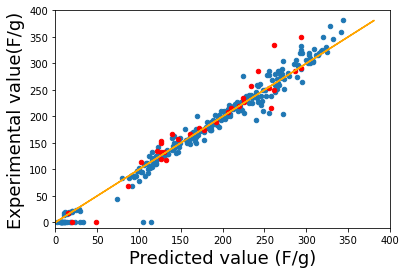

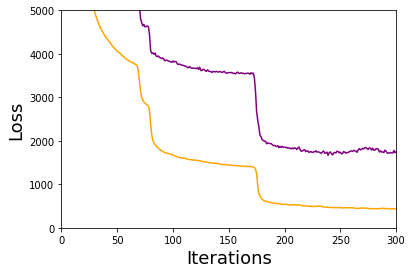

In [ ]:
#Initiate some arrays
k , i , Learning_curve = 10 , 0 , 0
kf = KFold(n_splits=k)
pred_train , pred_test = np.zeros((train_inputs.shape[0],k)) , np.zeros((test_inputs.shape[0],k)) 
train_val_acc=np.zeros((k,2))

#Split,CV,Preprocess
for train_index, validation_index in kf.split(train_targets):
  X_train, X_validation = train_inputs[train_index], train_inputs[validation_index]
  y_train, y_validation = train_targets[train_index], train_targets[validation_index]
  Test=test_inputs
  X_train_prep, X_validation_prep, X_test_prep = preprocess(X_train, X_validation,Test)

  #Model Here
  Learning_curve=ANN(X_train_prep,y_train,X_validation_prep,y_validation,X_test_prep,i,Learning_curve)
  i+=1

#Show Performance
perform(train_val_acc,pred_train,pred_test)
PlotLC(np.mean(Learning_curve,axis=2))

##SVR+CV

In [ ]:
def SVM(X_train,y_train,X_validation,y_validation,X_test,i,C=500):   #Model must update train_val_acc,pred_train,pred_test
  #Model
  reg=SVR(kernel='rbf', C=C, epsilon=15.0)
  reg.fit(X_train,y_train)
  #Predict and Evaluate
  train_val_acc[i,:]=np.array([reg.score(X_train,y_train),reg.score(X_validation,y_validation)])
  pred_train[:,i]=reg.predict(np.insert(X_train,validation_index[0],X_validation,axis=0))   #Unmix the pred_train for plotting
  pred_test[:,i]=reg.predict(X_test)

R-square on train is [0.93800337 0.94056352 0.93649345 0.95309893 0.94286494 0.94184219
 0.93967513 0.93701115 0.93857882 0.93916151]
R-square on validation is [0.8962224  0.76749488 0.83537092 0.73739523 0.72214474 0.88881043
 0.89093287 0.906118   0.91866115 0.83604316]
RMSE on train is [520.21094177 496.40581929 510.02089807 376.2016327  491.05916046
 506.0035009  503.65785353 515.69104859 512.3957296  494.15202606]
RMSE on validation is [ 708.55269482 1847.36766591 1774.34012599 2836.0877879  1363.12316807
  521.12109411  868.60964215  797.4412434   649.84884    1629.03274813]
Average R-square on train is 0.9407292998456205 Average R-square on validation is 0.8399193779445927
R-square on test set is 0.920474284442391
RMSE on test set is 592.1931500831618


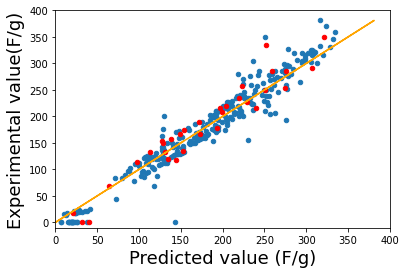

In [ ]:
#Initiate some arrays
k , i = 10 , 0
kf = KFold(n_splits=k)
pred_train , pred_test = np.zeros((train_inputs.shape[0],k)) , np.zeros((test_inputs.shape[0],k)) 
train_val_acc=np.zeros((k,2))

#Split,CV,Preprocess
for train_index, validation_index in kf.split(train_targets):
  X_train, X_validation = train_inputs[train_index], train_inputs[validation_index]
  y_train, y_validation = train_targets[train_index], train_targets[validation_index]
  Test=test_inputs
  X_train_prep, X_validation_prep, X_test_prep = preprocess(X_train, X_validation,Test)

  #Model Here
  SVM(X_train_prep,y_train,X_validation_prep,y_validation,X_test_prep,i)
  i+=1
#Show Performance
perform(train_val_acc,pred_train,pred_test)

In [ ]:
np.mean(pred_test,axis=1)

array([ 87.35623909, 141.12206888, 258.00396845, 196.28898478,
       151.61768318, 236.17786942, 183.51547669, 168.65933101,
       247.75847662, 129.03010179, 227.63154439, 155.6829174 ,
       249.72475064,  27.93915109, 271.56875103, 224.67279649,
       196.76905123, 104.39138003, 174.30727859, 308.38575424,
       205.31583429, 112.02339563, 138.15544614, 125.25874524,
       135.85102493, 167.53953751, 224.43311088, 320.60394654,
        46.77061255, 273.91060221,  12.93807583, 126.65560609])

Choosing C and epsilon (End up choosing epsilon=15, C=500)

(700, 2)


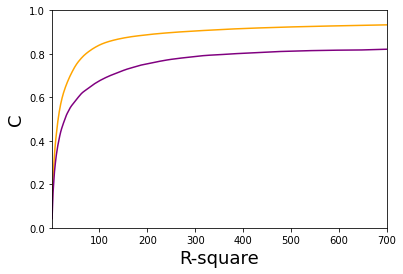

C that gives the highest on average validation set is 689
Best val performance is 0.8207311468973248


In [ ]:
#Initiate some arrays
Performance=np.zeros((700,2))
j , CBest , PerformBest= 0 , 0 , 0
for C in range(1,701):
  k , i = 10 , 0
  kf = KFold(n_splits=k)
  pred_train , pred_test = np.zeros((train_inputs.shape[0],k)) , np.zeros((test_inputs.shape[0],k)) 
  train_val_acc=np.zeros((k,2))
  #Split,CV,Preprocess
  for train_index, validation_index in kf.split(train_targets):
    X_train, X_validation = train_inputs[train_index], train_inputs[validation_index]
    y_train, y_validation = train_targets[train_index], train_targets[validation_index]
    Test=test_inputs
    X_train_prep, X_validation_prep, X_test_prep = preprocess(X_train, X_validation,Test)

    #Model Here
    SVM(X_train_prep,y_train,X_validation_prep,y_validation,X_test_prep,i,C)
    i+=1
  #Show Performance
  Performance[j,:]=np.mean(train_val_acc,axis=0)
  if Performance[j,:][1]>PerformBest+0.01:  #Set to 0.01 sensitivity 
    CBest=C
    PerformBest=Performance[j,:][1]
  j+=1
print(Performance.shape)
loss , val_loss = Performance[:,0] , Performance[:,1]
indices=np.linspace(1,700,num=700)
plt.plot(indices,loss,c='orange')
plt.plot(indices,val_loss,c='purple')
plt.xlabel("R-square", fontsize=18)
plt.ylabel("C", fontsize=18)
plt.xlim([1,700])
plt.ylim([0,1.0])
plt.show() 
print("C that gives the highest on average validation set is",CBest)
print("Best val performance is",PerformBest)

##Deep NN+CV+L2

In [ ]:
def DNN(X_train,y_train,X_validation,y_validation,X_test,i,Learning_curve):
  #Model
  input_size = 9
  output_size = 1
  hidden_layer_size_1 = 30
  hidden_layer_size_2 = 30
  max_epochs = 500
  model = tf.keras.Sequential([
        tf.keras.layers.Dense(hidden_layer_size_1, activation='tanh',kernel_regularizer=tf.keras.regularizers.L2(0.01)), # 1st hidden layer
        tf.keras.layers.Dense(hidden_layer_size_2, activation='tanh',kernel_regularizer=tf.keras.regularizers.L2(0.01)), # 2nd hidden layer
        tf.keras.layers.Dense(output_size, activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.01)) # output layer
    ])
  lr_schedule=0.1
  customized_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
  model.compile(optimizer=customized_optimizer, loss='mse', metrics=['mean_squared_error'])
  history=model.fit(X_train, # train inputs
            y_train, # train targets
            epochs=max_epochs, # epochs that we will train for
            validation_data=(X_validation, y_validation), # validation data
            verbose = 0 # making sure we get enough information about the training process 2 is reporting everything
            )
    
  #Predict and Evaluate
  train_val_acc[i,:]=np.array([r2_score(y_train,model.predict(X_train)),r2_score(y_validation,model.predict(X_validation))])
  pred_train[:,i]=model.predict(np.insert(X_train,validation_index[0],X_validation,axis=0)).reshape(-1,)
  pred_test[:,i]=model.predict(X_test).reshape(-1,)

  #Save model
  #filepath = F"/content/drive/MyDrive/ANN Model/3Fold"+str(i)    
  #tf.keras.models.save_model(model,filepath)
  print(i)
  
  #For Learning Curve
  if np.all(Learning_curve)==0:
    Learning_curve=np.ones((max_epochs,2,k)) #2 for train and val loss
  Learning_curve[:,0,i]=history.history['loss'] 
  Learning_curve[:,1,i]=history.history['val_loss']
  return Learning_curve

1/1 [==============================] - 0s 16ms/step
0
1/1 [==============================] - 0s 21ms/step
1
1/1 [==============================] - 0s 20ms/step
2
1/1 [==============================] - 0s 27ms/step
3
1/1 [==============================] - 0s 17ms/step
4
1/1 [==============================] - 0s 17ms/step
5
1/1 [==============================] - 0s 17ms/step
6
1/1 [==============================] - 0s 17ms/step
7
1/1 [==============================] - 0s 18ms/step
8
1/1 [==============================] - 0s 19ms/step
9
R-square on train is [0.96322617 0.95729118 0.95455216 0.9565125  0.93030934 0.91602636
 0.96942076 0.95549737 0.91979159 0.93330904]
R-square on validation is [0.66076665 0.63276666 0.6354467  0.54873569 0.66669889 0.68447973
 0.80554016 0.92530217 0.75755389 0.65675416]
RMSE on train is [308.56756727 356.6985723  364.99143748 348.82082447 598.97087307
 730.6147052  255.30885614 364.34394956 669.12495616 541.68788428]
RMSE on validation is [2316.15213661 

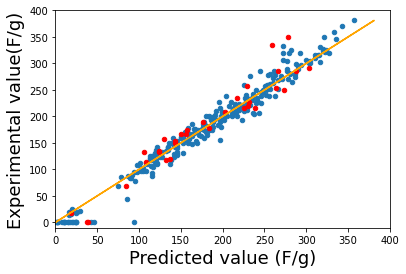

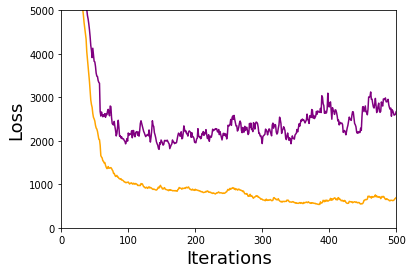

In [ ]:
#Initiate some arrays
k , i , Learning_curve = 10 , 0 , 0
kf = KFold(n_splits=k)
pred_train , pred_test = np.zeros((train_inputs.shape[0],k)) , np.zeros((test_inputs.shape[0],k)) 
train_val_acc=np.zeros((k,2))

#Split,CV,Preprocess
for train_index, validation_index in kf.split(train_targets):
  X_train, X_validation = train_inputs[train_index], train_inputs[validation_index]
  y_train, y_validation = train_targets[train_index], train_targets[validation_index]
  Test=test_inputs
  X_train_prep, X_validation_prep, X_test_prep = preprocess(X_train, X_validation,Test)

  #Model Here
  Learning_curve=DNN(X_train_prep,y_train,X_validation_prep,y_validation,X_test_prep,i,Learning_curve)
  i+=1

#Show Performance
perform(train_val_acc,pred_train,pred_test)
PlotLC(np.mean(Learning_curve,axis=2))

##GPR+CV

In [ ]:
def GPR(X_train,y_train,X_validation,y_validation,X_test,i):   #Model must update train_val_acc,pred_train,pred_test
  #Model
  gpr=GaussianProcessRegressor(alpha=10,kernel=kernels.ConstantKernel(1.0, constant_value_bounds=(1e-5,10000000)) * kernels.RBF(1.0, length_scale_bounds="fixed"),n_restarts_optimizer=2)
  gpr.fit(X_train,y_train)
  log_marg[:,i]=np.array([gpr.log_marginal_likelihood()])
  #Predict and Evaluate
  train_val_acc[i,:]=np.array([gpr.score(X_train,y_train),gpr.score(X_validation,y_validation)])
  pred_train[:,i]=gpr.predict(np.insert(X_train,validation_index[0],X_validation,axis=0))   #Unmix the pred_train for plotting
  pred_test[:,i]=gpr.predict(X_test)

R-square on train is [0.99985477 0.99986707 0.99982897 0.99987635 0.99986573 0.99990676
 0.99987962 0.99988451 0.99984586 0.99989278]
R-square on validation is [0.96063246 0.93956081 0.93747842 0.89810761 0.80953046 0.78722215
 0.94510875 0.8444853  0.70883453 0.79381014]
RMSE on train is [1.21865462 1.11021684 1.37355167 0.99182045 1.15397977 0.8112238
 1.00509964 0.94551191 1.28586614 0.8708747 ]
RMSE on validation is [ 268.78607715  480.21911196  673.84539395 1100.42088139  934.41974141
  997.24304591  437.15341662 1320.95428677 2326.23834758 2048.64909264]
Average R-square on train is 0.9998702418571005 Average R-square on validation is 0.8624770638789885
R-square on test set is 0.9486409575301952
RMSE on test set is 382.4482801844912


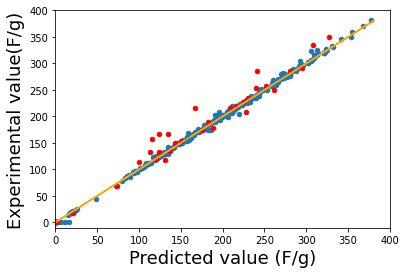

[-1321.0623319]


In [ ]:
#Initiate some arrays
k , i = 10 , 0
kf = KFold(n_splits=k)
pred_train , pred_test = np.zeros((train_inputs.shape[0],k)) , np.zeros((test_inputs.shape[0],k)) 
train_val_acc , TSS = np.zeros((k,2)) , np.zeros((k,2))
log_marg = np.zeros((1,k))

#Split,CV,Preprocess
for train_index, validation_index in kf.split(train_targets):
  X_train, X_validation = train_inputs[train_index], train_inputs[validation_index]
  y_train, y_validation = train_targets[train_index], train_targets[validation_index]
  Test=test_inputs
  X_train_prep, X_validation_prep, X_test_prep = preprocess(X_train, X_validation,Test)
  TSS[i,0]=np.mean((y_train-np.mean(y_train))**2)
  TSS[i,1]=np.mean((y_validation-np.mean(y_validation))**2)

  #Model Here
  GPR(X_train_prep,y_train,X_validation_prep,y_validation,X_test_prep,i)
  i+=1
#Show Performance
perform(train_val_acc,pred_train,pred_test)
print(np.mean(log_marg,axis=1))

##GLR+CV

In [ ]:
def GLR(X_train,y_train,X_validation,y_validation,X_test,i):   #Model must update train_val_acc,pred_train,pred_test
  #Model
  #reg=LinearRegression()
  reg=Ridge(alpha=10.0)
  reg.fit(X_train,y_train)
  coef[:,i]=reg.coef_
  #Predict and Evaluate
  train_val_acc[i,:]=np.array([reg.score(X_train,y_train),reg.score(X_validation,y_validation)])
  pred_train[:,i]=reg.predict(np.insert(X_train,validation_index[0],X_validation,axis=0))   #Unmix the pred_train for plotting
  pred_test[:,i]=reg.predict(X_test)

R-square on train is [0.81221788 0.81086526 0.81285887 0.82055882 0.82716248 0.81457524
 0.81565307 0.80356215 0.80585094 0.83230854]
R-square on validation is [0.38340066 0.72084935 0.74317472 0.66841783 0.52249904 0.72850496
 0.70847714 0.83088303 0.78765082 0.28907093]
RMSE on train is [1575.67130393 1579.62895216 1502.92986838 1439.32885745 1485.48803337
 1613.29272144 1539.12926958 1608.24080942 1619.65541081 1362.05017296]
RMSE on validation is [4209.8981956  2217.98931693 2768.01277731 3581.03229149 2342.56003338
 1272.43762245 2321.68535695 1436.49303106 1696.54325547 7063.60742902]
Average R-square on train is 0.8155613246150917 Average R-square on validation is 0.6382928474617797
R-square on test set is 0.7690604846963156
RMSE on test set is 1719.7053567823214


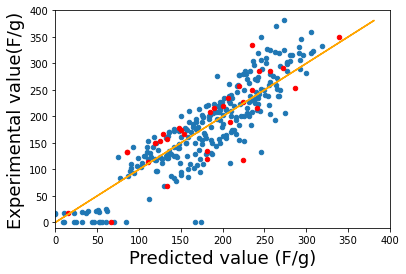

In [ ]:
#Initiate some arrays
k , i = 10 , 0
kf = KFold(n_splits=k)
pred_train , pred_test = np.zeros((train_inputs.shape[0],k)) , np.zeros((test_inputs.shape[0],k)) 
train_val_acc , TSS =np.zeros((k,2)) , np.zeros((k,2))
coef = np.zeros((55,k))

#Split,CV,Preprocess
for train_index, validation_index in kf.split(train_targets):
  X_train, X_validation = train_inputs[train_index], train_inputs[validation_index]
  y_train, y_validation = train_targets[train_index], train_targets[validation_index]
  Test = test_inputs
  X_train_prep, X_validation_prep, X_test_prep = preprocess(X_train, X_validation,Test)
  poly = PolynomialFeatures(degree=2)
  poly_train_inputs=poly.fit_transform(X_train_prep)
  poly_validation_inputs=poly.transform(X_validation_prep)
  poly_test_inputs=poly.transform(X_test_prep)
  TSS[i,0]=np.mean((y_train-np.mean(y_train))**2)
  TSS[i,1]=np.mean((y_validation-np.mean(y_validation))**2)

    #Model Here
  GLR(poly_train_inputs,y_train,poly_validation_inputs,y_validation,poly_test_inputs,i)
  i+=1
  #Show Performance
perform(train_val_acc,pred_train,pred_test)

In [ ]:
np.mean(pred_test,axis=1)

array([133.94653433, 134.16623471, 256.94682016, 185.38366563,
       150.21036227, 241.18691371, 148.0741002 , 128.52939276,
       234.69075605, 119.66235014, 224.78821157, 224.84548267,
       235.31992995,  -5.45591105, 286.81086944, 205.87884307,
       189.90125512, 111.01402439, 208.77274598, 271.690154  ,
       200.75571415,  85.93607505, 153.35280063,  85.8020157 ,
       181.24197857, 181.85328192, 219.08193769, 339.25007968,
        66.5841417 , 244.0107736 ,  15.67965366, 124.90921862])